In [17]:
'''
Target model definitions that adverserial examples are attempting to 'fool':

ref: https://arxiv.org/pdf/1801.02610.pdf

Source Code on attack perfomance on MINST Challenge and Cifar10:

https://github.com/ctargon/AdvGAN-tf
'''

import tensorflow as tf
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os, sys
import random

from generator import generator
from discriminator import discriminator
from keras.datasets import mnist
from keras.datasets import cifar10
from keras.datasets import cifar100
#from target_models import Target as target_model

In [23]:
class Target:
    def __init__(self, lr=0.001, epochs=5, n_input=32, n_classes = 20, batch_size = 64,restore =0):
        self.lr = lr
        self.epochs = epochs
        self.n_input = n_input
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.restore = restore

        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

    # randomly shuffle a dataset 
    def shuffle(self, X, Y):
        rands = random.sample(range(X.shape[0]),X.shape[0])
        return X[rands], Y[rands]

    # get the next batch based on x, y, and the iteration (based on batch_size)
    def next_batch(self, X, Y, i, batch_size):
        idx = i * batch_size
        idx_n = i * batch_size + batch_size
        return X[idx:idx_n], Y[idx:idx_n]
    
    

    # USAGE:
    # - encoder network for vae
    # PARAMS:
    #x: input data sample
    #h_hidden: LIST of num. neurons per hidden layer
    def ModelC(self, x):
        with tf.variable_scope('ModelC', reuse=tf.AUTO_REUSE):
            #input_layer = tf.reshape(x, [-1, 28, 28, 1])

            conv1 = tf.layers.conv2d(
                                inputs=x,
                                filters=32,
                                kernel_size=3,
                                padding="same",
                                activation=tf.nn.relu)
            
            conv2 = tf.layers.conv2d(
                                inputs=conv1,
                                filters=32,
                                kernel_size=3,
                                padding="same",
                                activation=tf.nn.relu)

            pool1 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

            conv3 = tf.layers.conv2d(
                                inputs=pool1,
                                filters=64,
                                kernel_size=3,
                                padding="same",
                                activation=tf.nn.relu)

            conv4 = tf.layers.conv2d(
                                inputs=conv3,
                                filters=64,
                                kernel_size=3,
                                padding="same",
                                activation=tf.nn.relu)

            pool2 = tf.layers.max_pooling2d(inputs=conv4, pool_size=[2, 2], strides=2)

            pool2_flatten = tf.contrib.layers.flatten(pool2)

            fc1 = tf.layers.dense(inputs=pool2_flatten, units=200, activation=tf.nn.relu)

            fc2 = tf.layers.dense(inputs=fc1, units=200, activation=tf.nn.relu)

            logits = tf.layers.dense(inputs=fc2, units=self.n_classes, activation=None)

            probs = tf.nn.softmax(logits)

            return logits, probs



    def train(self, X, Y, X_test, Y_test):
        # define placeholders for input data
        x = tf.placeholder(tf.float32, [None, X.shape[1], X.shape[2], X.shape[3]])
        y = tf.placeholder(tf.float32, [None, self.n_classes])

        # define compute graph
        logits, _ = self.ModelC(x)

        # define cost
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y))

        # optimizer
        optimizer = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(cost)
        saver = tf.train.Saver()

        # Initializing the variables
        init = tf.global_variables_initializer()

        sess = tf.Session()
        sess.run(init)

        total_batch = int(X.shape[0] / self.batch_size)

        for epoch in range(1, self.epochs + 1):
            avg_cost = 0.

            for i in range(total_batch):
                batch_x, batch_y = self.next_batch(X, Y, i, self.batch_size)
                
                _, c = sess.run([optimizer, cost], feed_dict={x: batch_x, y: batch_y})

                avg_cost += c / total_batch

            print("Epoch:", '%04d' % (epoch), "cost=", "{:.9f}".format(avg_cost))

        # Test model
        correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))

        # Calculate accuracy
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        accs = []

        total_test_batch = int(X_test.shape[0] / self.batch_size)
        for i in range(total_test_batch):
            batch_x, batch_y = self.next_batch(X_test, Y_test, i, self.batch_size)
            #batch_x = dataset.train.permute(batch_x, idxs)
            accs.append(accuracy.eval({x: batch_x, y: batch_y}, session=sess))

        print('accuracy of test set: {}'.format(sum(accs) / len(accs)))

        saver.save(sess, "./weights/target_model/model.ckpt")
        sess.close() 


The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [24]:
tf.reset_default_graph()
num_classes=20
batch_size = 64
restore = 0

#if __name__ == '__main__':
(X,y), (X_test,y_test) = cifar100.load_data(label_mode = 'coarse')#cifar10.load_data()
X = np.divide(X, 255.0)
X_test = np.divide(X_test, 255.0)
X = X.reshape(X.shape[0], 32, 32, 3)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
y = to_categorical(y, num_classes)
y_test = to_categorical(y_test, num_classes)
cnn = Target()
cnn.train(X, y, X_test, y_test)

Epoch: 0001 cost= 2.309605431
Epoch: 0002 cost= 1.824912320
Epoch: 0003 cost= 1.555167047
Epoch: 0004 cost= 1.349178161
Epoch: 0005 cost= 1.180801576
accuracy of test set: 0.49719551282051283


In [25]:
# randomly shuffle a dataset 
def shuffle(X, Y):
    rands = random.sample(range(X.shape[0]),X.shape[0])
    return X[rands], Y[rands]

In [26]:
# get the next batch based on x, y, and the iteration (based on batch_size)
def next_batch(X, Y, i, batch_size):
    idx = i * batch_size
    idx_n = i * batch_size + batch_size
    return X[idx:idx_n], Y[idx:idx_n]

In [27]:
def adv_loss(preds, labels, is_targeted):
    real = tf.reduce_sum(labels * preds, 1)
    other = tf.reduce_max((1 - labels) * preds - (labels * 10000), 1)
    if is_targeted:
        return tf.reduce_sum(tf.maximum(0.0, other - real))
    return tf.reduce_sum(tf.maximum(0.0, real - other))

In [28]:
# loss function to influence the perturbation to be as close to 0 as possible
def perturb_loss(preds, thresh=0.3):
    zeros = tf.zeros((tf.shape(preds)[0]))
    return tf.reduce_mean(tf.maximum(zeros, tf.norm(tf.reshape(preds, (tf.shape(preds)[0], -1)), axis=1) - thresh))

In [29]:
# function that defines ops, graphs, and training procedure for AdvGAN framework
def AdvGAN(X, y, X_test, y_test, n_classes, epochs=50, batch_size=128, target=-1):
    # placeholder definitions
    x_pl = tf.placeholder(tf.float32, [None, X.shape[1], X.shape[2], X.shape[3]]) # image placeholder
    t = tf.placeholder(tf.float32, [None, y.shape[-1]]) # target placeholder
    is_training = tf.placeholder(tf.bool, [])

    #-----------------------------------------------------------------------------------
    # MODEL DEFINITIONS
    is_targeted = False
    if target in range(0, y.shape[-1]):
        is_targeted = True

    # gather target model
    f = Target(n_classes, batch_size,restore = 0) #target_model()

    thresh = 0.3

    # generate perturbation, add to original input image(s)
    perturb = tf.clip_by_value(generator(x_pl, is_training), -thresh, thresh)
    x_perturbed = perturb + x_pl
    x_perturbed = tf.clip_by_value(x_perturbed, 0, 1)

    # pass real and perturbed image to discriminator and the target model
    d_real_logits, d_real_probs = discriminator(x_pl, is_training)
    d_fake_logits, d_fake_probs = discriminator(x_perturbed, is_training)

    # pass real and perturbed images to the model we are trying to fool
    f_real_logits, f_real_probs = f.ModelC(x_pl)
    f_fake_logits, f_fake_probs = f.ModelC(x_perturbed)


    # generate labels for discriminator (optionally smooth labels for stability)
    smooth = 0.0
    d_labels_real = tf.ones_like(d_real_probs) * (1 - smooth)
    d_labels_fake = tf.zeros_like(d_fake_probs)

    #-----------------------------------------------------------------------------------
    # LOSS DEFINITIONS
    # discriminator loss
    d_loss_real = tf.losses.mean_squared_error(predictions=d_real_probs, labels=d_labels_real)
    d_loss_fake = tf.losses.mean_squared_error(predictions=d_fake_probs, labels=d_labels_fake)
    d_loss = d_loss_real + d_loss_fake

    # generator loss
    g_loss_fake = tf.losses.mean_squared_error(predictions=d_fake_probs, labels=tf.ones_like(d_fake_probs))

    # perturbation loss (minimize overall perturbation)
    l_perturb = perturb_loss(perturb, thresh)

    # adversarial loss (encourage misclassification)
    l_adv = adv_loss(f_fake_probs, t, is_targeted)

    # weights for generator loss function
    alpha = 1.0
    beta = 5.0
    g_loss = l_adv + alpha*g_loss_fake + beta*l_perturb 

    # ----------------------------------------------------------------------------------
    # gather variables for training/restoring
    t_vars = tf.trainable_variables()
    f_vars = [var for var in t_vars if 'ModelC' in var.name]
    d_vars = [var for var in t_vars if 'd_' in var.name]
    g_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='g_weights')

    # define optimizers for discriminator and generator
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        d_opt = tf.train.AdamOptimizer().minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate=0.001).minimize(g_loss, var_list=g_vars)

    # create saver objects for the target model, generator, and discriminator
    saver = tf.train.Saver(f_vars)
    g_saver = tf.train.Saver(g_vars)
    d_saver = tf.train.Saver(d_vars)

    init  = tf.global_variables_initializer()

    sess  = tf.Session()
    sess.run(init)

    # load the pretrained target model
    try:
        saver.restore(sess, "./weights/target_model/model.ckpt")
    except:
        print("make sure to train the target model first...")
        sys.exit(1)

    total_batches = int(X.shape[0] / batch_size)

    for epoch in range(0, epochs):

        X, y = shuffle(X, y)
        loss_D_sum = 0.0
        loss_G_fake_sum = 0.0
        loss_perturb_sum = 0.0
        loss_adv_sum = 0.0

        for i in range(total_batches):

            batch_x, batch_y = next_batch(X, y, i, batch_size)

            # if targeted, create one hot vectors of the target
            if is_targeted:
                targets = np.full((batch_y.shape[0],), target)
                batch_y = np.eye(y.shape[-1])[targets]

            # train the discriminator first n times
            for _ in range(1):
                _, loss_D_batch = sess.run([d_opt, d_loss], feed_dict={x_pl: batch_x, \
                                                                       is_training: True})

            # train the generator n times
            for _ in range(1):
                _, loss_G_fake_batch, loss_adv_batch, loss_perturb_batch = \
                                    sess.run([g_opt, g_loss_fake, l_adv, l_perturb], \
                                                feed_dict={x_pl: batch_x, \
                                                           t: batch_y, \
                                                           is_training: True})
            loss_D_sum += loss_D_batch
            loss_G_fake_sum += loss_G_fake_batch
            loss_perturb_sum += loss_perturb_batch
            loss_adv_sum += loss_adv_batch

        print("epoch %d:\nloss_D: %.3f, loss_G_fake: %.3f, \
                \nloss_perturb: %.3f, loss_adv: %.3f, \n" %
                (epoch + 1, loss_D_sum/total_batches, loss_G_fake_sum/total_batches,
                loss_perturb_sum/total_batches, loss_adv_sum/total_batches))

        if epoch % 10 == 0:
            g_saver.save(sess, "weights/generator/gen.ckpt")
            d_saver.save(sess, "weights/discriminator/disc.ckpt")

    # evaluate the test set
    correct_prediction = tf.equal(tf.argmax(f_fake_probs, 1), tf.argmax(t, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    accs = []
    total_batches_test = int(X_test.shape[0] / batch_size)
    for i in range(total_batches_test):
        batch_x, batch_y = next_batch(X_test, y_test, i, batch_size)
        acc, x_pert = sess.run([accuracy, x_perturbed], feed_dict={x_pl: batch_x, t: batch_y, is_training: False})
        accs.append(acc)

    print('accuracy of test set: {}'.format(sum(accs) / len(accs)))

    # plot some images and their perturbed counterparts
    f, axarr = plt.subplots(2,2)
    axarr[0,0].imshow(np.squeeze(batch_x[2]), cmap='Greys_r')
    axarr[0,1].imshow(np.squeeze(x_pert[2]), cmap='Greys_r')
    axarr[1,0].imshow(np.squeeze(batch_x[5]), cmap='Greys_r')
    axarr[1,1].imshow(np.squeeze(x_pert[5]), cmap='Greys_r')
    plt.show()

    print('finished training, saving weights')
    return batch_x, x_pert
    #g_saver.save(sess, "weights/generator/gen.ckpt")
    #d_saver.save(sess, "weights/discriminator/disc.ckpt")

In [30]:
def attack(X, y, batch_size=128, thresh=0.3, target=-1):
    x_pl = tf.placeholder(tf.float32, [None, X.shape[1], X.shape[2], X.shape[3]]) # image placeholder
    t = tf.placeholder(tf.float32, [None, 10]) # target placeholder
    is_training = tf.placeholder(tf.bool, [])

    is_targeted = False
    if target in range(0, y.shape[-1]):
        is_targeted = True

    perturb = tf.clip_by_value(generator(x_pl, is_training), -thresh, thresh)
    x_perturbed = perturb + x_pl
    x_perturbed = tf.clip_by_value(x_perturbed, 0, 1)

    f = Target()
    f_real_logits, f_real_probs = f.ModelC(x_pl)
    f_fake_logits, f_fake_probs = f.ModelC(x_perturbed)

    t_vars = tf.trainable_variables()
    f_vars = [var for var in t_vars if 'ModelC' in var.name]
    g_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='g_weights')

    sess = tf.Session()

    f_saver = tf.train.Saver(f_vars)
    g_saver = tf.train.Saver(g_vars)
    f_saver.restore(sess, "./weights/target_model/model.ckpt")
    g_saver.restore(sess, "./weights/generator/gen.ckpt")
    #g_saver.restore(sess, tf.train.latest_checkpoint("./weights/generator/"))

    rawpert, pert, fake_l, real_l = sess.run([perturb, x_perturbed, f_fake_probs, f_real_probs], \
                                                feed_dict={x_pl: X[:32], \
                                                           is_training: False})
    print('LA: ' + str(np.argmax(y[:32], axis=1)))
    print('OG: ' + str(np.argmax(real_l, axis=1)))
    print('PB: ' + str(np.argmax(fake_l, axis=1)))

    correct_prediction = tf.equal(tf.argmax(f_fake_probs, 1), tf.argmax(t, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    accs = []
    total_batches_test = int(X.shape[0] / batch_size)
    for i in range(total_batches_test):
        batch_x, batch_y = next_batch(X, y, i, batch_size)

        if is_targeted:
            targets = np.full((batch_y.shape[0],), target)
            batch_y = np.eye(y.shape[-1])[targets]

        acc, fake_l, x_pert = sess.run([accuracy, f_fake_probs, x_perturbed], feed_dict={x_pl: batch_x, t: batch_y, is_training: False})
        accs.append(acc)

    print('accuracy of test set: {}'.format(sum(accs) / len(accs)))

    f, axarr = plt.subplots(2,2)
    axarr[0,0].imshow(np.squeeze(X[3]), cmap='Greys_r')
    axarr[0,1].imshow(np.squeeze(pert[3]), cmap='Greys_r')
    axarr[1,0].imshow(np.squeeze(X[4]), cmap='Greys_r')
    axarr[1,1].imshow(np.squeeze(pert[4]), cmap='Greys_r')
    plt.show()
    
    return pert, X


In [ ]:
tf.reset_default_graph()
# read in mnist data
#(X,y), (X_test,y_test) = mnist.load_data()
(X, y), (X_test, y_test) = cifar100.load_data(label_mode = 'coarse')
X = np.divide(X, 255.0)
X_test = np.divide(X_test, 255.0)
X = X.reshape(X.shape[0], 32, 32, 3)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
y = to_categorical(y, num_classes=20)
y_test = to_categorical(y_test, num_classes=20)

batch_x, pert_x = AdvGAN(X, y, X_test, y_test, num_classes, batch_size=64, epochs=5, target=-1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

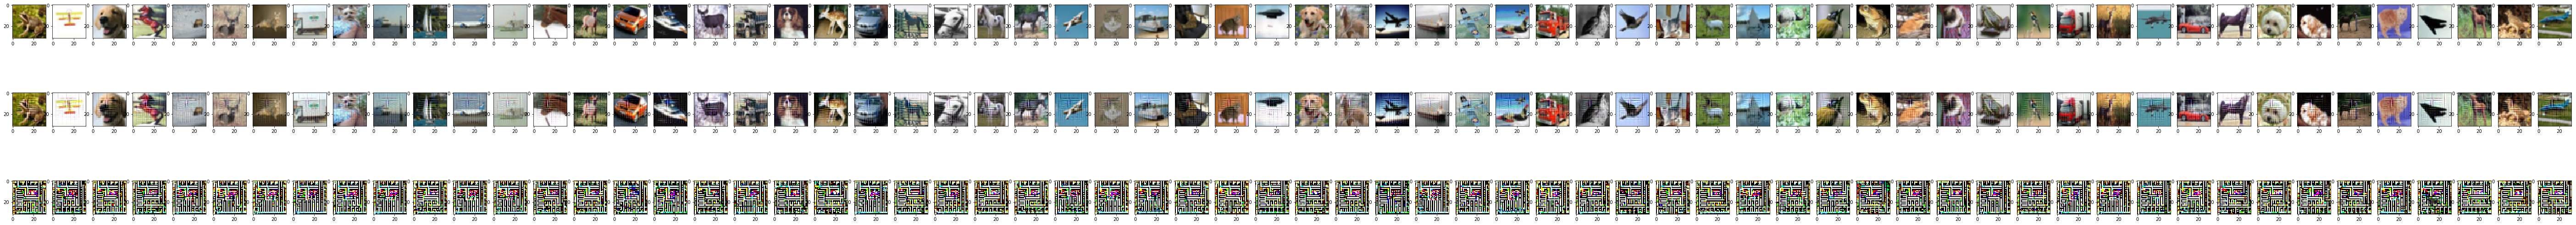

In [16]:
f, axarr = plt.subplots(3,64, figsize = (100,10))
dif_x = (batch_x-pert_x)*100
dif_x
for i in range(0,64):
    axarr[0,i].imshow(np.squeeze(batch_x[i]), cmap='Greys_r')
    axarr[1,i].imshow(np.squeeze(pert_x[i]), cmap='Greys_r')
    axarr[2,i].imshow(np.squeeze(dif_x[i]), cmap='Greys_r')

In [ ]:
X_per, X_a = attack(X_test, y_test, target=-1)

In [36]:
X.shape

(50000, 32, 32, 3)

In [37]:
X[0]

array([[[0.23137255, 0.24313725, 0.24705882],
        [0.16862745, 0.18039216, 0.17647059],
        [0.19607843, 0.18823529, 0.16862745],
        ...,
        [0.61960784, 0.51764706, 0.42352941],
        [0.59607843, 0.49019608, 0.4       ],
        [0.58039216, 0.48627451, 0.40392157]],

       [[0.0627451 , 0.07843137, 0.07843137],
        [0.        , 0.        , 0.        ],
        [0.07058824, 0.03137255, 0.        ],
        ...,
        [0.48235294, 0.34509804, 0.21568627],
        [0.46666667, 0.3254902 , 0.19607843],
        [0.47843137, 0.34117647, 0.22352941]],

       [[0.09803922, 0.09411765, 0.08235294],
        [0.0627451 , 0.02745098, 0.        ],
        [0.19215686, 0.10588235, 0.03137255],
        ...,
        [0.4627451 , 0.32941176, 0.19607843],
        [0.47058824, 0.32941176, 0.19607843],
        [0.42745098, 0.28627451, 0.16470588]],

       ...,

       [[0.81568627, 0.66666667, 0.37647059],
        [0.78823529, 0.6       , 0.13333333],
        [0.77647059, 0

In [5]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [20]:
cnn

In [50]:
cnn.ModelC

<bound method Target.ModelC of <__main__.Target object at 0x000002379CAF2438>>